In [185]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
import torch
from torch import nn
from torch import optim

from utils import utils
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [186]:
class IsihDanns:
    """
    TODO: Attach paper
    """
    def __init__(self, input_size: int, hidden_size: int, lr_dim1: float, lr_dim2: float, num_epochs_dim1: int, num_epochs_dim2: int):
        self.feature_extractor = utils.Conv1d(input_size=input_size).to(DEVICE)
        self.domain_classifier_dim1 = utils.Decoder(input_size=hidden_size, output_size=1).to(DEVICE)
        self.task_classifier_dim1 = utils.Decoder(input_size=hidden_size, output_size=1).to(DEVICE)
        self.feature_optimizer_dim1 = optim.Adam(self.feature_extractor.parameters(), lr=lr_dim1)
        self.domain_optimizer_dim1 = optim.Adam(self.domain_classifier_dim1.parameters(), lr=lr_dim1)
        self.task_optimizer_dim1 = optim.Adam(self.task_classifier_dim1.parameters(), lr=lr_dim1)
        self.criterion = nn.BCELoss()
        self.num_epochs_dim1 = num_epochs_dim1

        self.domain_classifier_dim2 = utils.Decoder(input_size=hidden_size, output_size=1).to(DEVICE)
        self.task_classifier_dim2 = utils.Decoder(input_size=hidden_size, output_size=1).to(DEVICE)
        self.feature_optimizer_dim2 = optim.Adam(self.feature_extractor.parameters(), lr=lr_dim2)
        self.domain_optimizer_dim2 = optim.Adam(self.domain_classifier_dim2.parameters(), lr=lr_dim2)
        self.task_optimizer_dim2 = optim.Adam(self.task_classifier_dim2.parameters(), lr=lr_dim2)
        self.num_epochs_dim2 = num_epochs_dim2

    def fit_1st_dim(self, source_loader, target_loader, test_target_X: torch.Tensor, test_target_y_task: torch.Tensor):
        self.feature_extractor, self.task_classifier_dim1, _ = utils.fit(
            source_loader, target_loader, test_target_X, test_target_y_task,
            self.feature_extractor, self.domain_classifier_dim1, self.task_classifier_dim1, self.criterion,
            self.feature_optimizer_dim1, self.domain_optimizer_dim1, self.task_optimizer_dim1, num_epochs=self.num_epochs_dim1, do_plot=True
        )

    def fit_2nd_dim(self, source_loader, target_loader, test_target_X: torch.Tensor, test_target_y_task: torch.Tensor):
        self.feature_extractor, self.task_classifier_dim2, _ = utils.fit(
            source_loader, target_loader, test_target_X, test_target_y_task,
            self.feature_extractor, self.domain_classifier_dim2, self.task_classifier_dim2, self.criterion,
            self.feature_optimizer_dim2, self.domain_optimizer_dim2, self.task_optimizer_dim2, num_epochs=self.num_epochs_dim2, is_psuedo_weights=True, do_plot=True
        )

    def predict(self, X: torch.Tensor, is_1st_dim: bool) -> torch.Tensor:
        if is_1st_dim:
            out = self.task_classifier_dim1(self.feature_extractor(X))
            out = torch.sigmoid(out).reshape(-1)
            return out
        else:
            out = self.task_classifier_dim2(self.feature_extractor(X))
            out = torch.sigmoid(out).reshape(-1)
            return out

In [187]:
source_idx = 1
shift_size = 3

train_source_X = pd.read_csv(f"./deep_occupancy_detection/data/{source_idx}_X_train.csv")
train_source_y_task = pd.read_csv(f"./deep_occupancy_detection/data/{source_idx}_Y_train.csv")[train_source_X.Season == 1]
train_source_X = train_source_X[train_source_X.Season == 1]

target_X = train_source_X.copy()
tmp_list = [i for i in range(16, 44, 1)]
tmp_list += [12, 13, 14, 15]
tmp_list = tmp_list * int((train_source_X.shape[0]/31)-1)
target_X["Time"] = tmp_list
target_y_task = train_source_y_task

train_source_y_task = train_source_y_task.values.reshape(-1)
target_y_task = target_y_task.values.reshape(-1)

In [188]:
train_source_X

,Energy,Season,Time
0,471791.255,1,12
1,403413.570,1,13
2,145718.019,1,14
3,210867.162,1,15
4,340747.424,1,16
...,...,...,...
1243,372609.934,1,39
1244,765374.943,1,40
1245,316438.865,1,41
1246,1419247.455,1,42


In [189]:
target_X

,Energy,Season,Time
0,471791.255,1,16
1,403413.570,1,17
2,145718.019,1,18
3,210867.162,1,19
4,340747.424,1,20
...,...,...,...
1243,372609.934,1,43
1244,765374.943,1,12
1245,316438.865,1,13
1246,1419247.455,1,14


(array([17.,  8.,  5.,  3.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([ 115555.763  ,  219204.80828,  322853.85356,  426502.89884,
         530151.94412,  633800.9894 ,  737450.03468,  841099.07996,
         944748.12524, 1048397.17052, 1152046.2158 , 1255695.26108,
        1359344.30636, 1462993.35164, 1566642.39692, 1670291.4422 ,
        1773940.48748, 1877589.53276, 1981238.57804, 2084887.62332,
        2188536.6686 , 2292185.71388, 2395834.75916, 2499483.80444,
        2603132.84972, 2706781.895  ]),
 <a list of 25 Patch objects>)

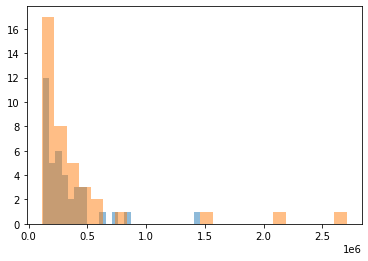

In [190]:
plt.hist(train_source_X[train_source_X.Time==12].Energy, bins=25, alpha=0.5)
plt.hist(target_X[target_X.Time==12].Energy, bins=25, alpha=0.5)

(array([6., 4., 5., 5., 3., 2., 6., 1., 1., 1., 1., 0., 0., 3., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1.]),
 array([114143.083 , 139603.0832, 165063.0834, 190523.0836, 215983.0838,
        241443.084 , 266903.0842, 292363.0844, 317823.0846, 343283.0848,
        368743.085 , 394203.0852, 419663.0854, 445123.0856, 470583.0858,
        496043.086 , 521503.0862, 546963.0864, 572423.0866, 597883.0868,
        623343.087 , 648803.0872, 674263.0874, 699723.0876, 725183.0878,
        750643.088 ]),
 <a list of 25 Patch objects>)

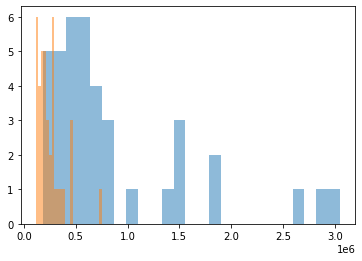

In [191]:
plt.hist(train_source_X[train_source_X.Time==43].Energy, bins=25, alpha=0.5)
plt.hist(target_X[target_X.Time==43].Energy, bins=25, alpha=0.5)

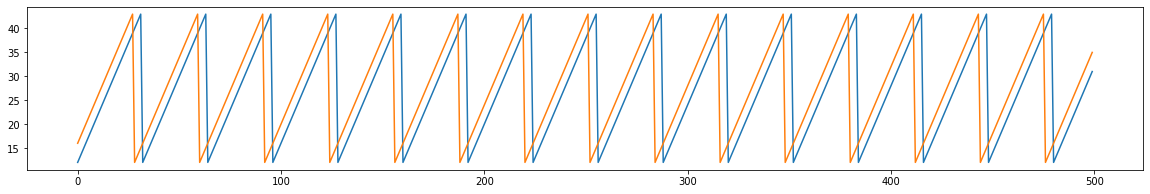

In [178]:
plt.figure(figsize=(20, 3))
plt.plot(train_source_X.Time[:500])
plt.plot(target_X.Time[:500])

In [179]:
scaler = preprocessing.StandardScaler()
train_source_X = scaler.fit_transform(train_source_X)
target_X = scaler.fit_transform(target_X)

train_source_X, train_source_y_task = utils.apply_sliding_window(train_source_X, train_source_y_task, filter_len=6)
target_X, target_y_task = utils.apply_sliding_window(target_X, target_y_task, filter_len=6)

train_target_X, test_target_X, train_target_y_task, test_target_y_task = target_X, target_X, target_y_task, target_y_task
source_loader, target_loader, train_source_y_task, train_source_X, _, _ = utils.get_loader(train_source_X, train_target_X, train_source_y_task, train_target_y_task, shuffle=True)

test_target_X = torch.tensor(test_target_X, dtype=torch.float32)
test_target_y_task = torch.tensor(test_target_y_task, dtype=torch.float32)
test_target_X = test_target_X.to(DEVICE)
test_target_y_task = test_target_y_task.to(DEVICE)

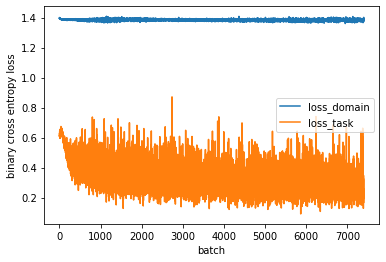

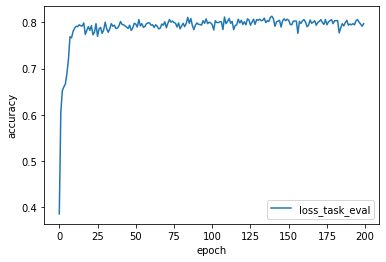

In [180]:
isih_dann = IsihDanns(input_size=train_source_X.shape[2], hidden_size=128, lr_dim1=0.0001, lr_dim2=0.00005, 
                      num_epochs_dim1=200, num_epochs_dim2=100)
isih_dann.fit_1st_dim(source_loader, target_loader, test_target_X, test_target_y_task)


In [181]:
pred_y_task = isih_dann.predict(test_target_X, is_1st_dim=True)
pred_y_task = pred_y_task > 0.5
sum(test_target_y_task == pred_y_task) / pred_y_task.shape[0]

tensor(0.7973, device='cuda:0')

In [182]:
pred_y_task = isih_dann.predict(train_source_X, is_1st_dim=True)
pred_y_task = pred_y_task > 0.5
sum(train_source_y_task.reshape(-1) == pred_y_task.detach().cpu().numpy()) / pred_y_task.shape[0]

0.8897827835880934